In [23]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bertbasecased/config.json
/kaggle/input/bertbasecased/tokenizer.json
/kaggle/input/bertbasecased/tokenizer_config.json
/kaggle/input/bertbasecased/pytorch_model.bin
/kaggle/input/bertbasecased/vocab.txt
/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/config.json
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/tokenizer.json
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/tf_model.h5
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/pytorch_model.bin
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/vocab.txt
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/flax_model.msgpack


In [24]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [25]:
kf = KFold(n_splits=5)
kfolds_data = kf.split(train_data_raw)

partition = 1
for train_index, test_index in kfolds_data:
    train = pd.DataFrame(train_data_raw.values[train_index])
    train.columns = train_data_raw.columns

#     test = pd.DataFrame(train_data_raw.values[test_index])
#     test.columns = train_data_raw.columns
    
    train.to_csv(f'/kaggle/working/train_partition_{partition}.csv')
#     test.to_csv(f'/kaggle/working/test_partition_{partition}.csv')
    
    partition +=1
    
train = pd.read_csv('/kaggle/working/train_partition_1.csv').iloc[:,1:]

In [26]:
test['full_text']

0    when a person has no experience on a job their...
1    Do you think students would benefit from being...
2    Thomas Jefferson once states that "it is wonde...
Name: full_text, dtype: object

In [27]:
#tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bertbasecased/")

#essay =  train['full_text'][0]
longest_essay_length = train['full_text'].apply(len).max()

def tokenize(essays):
    return [
            tokenizer.encode(
            x,
            padding='max_length',
            max_length=longest_essay_length,
            truncation=True,
            add_special_tokens= False, #if treue [CLS] and [SEP] get added to each tokenizing.
            ) for x in essays]

encoded_essays_train = tokenize(train['full_text'])
encoded_essays_train = tf.convert_to_tensor(encoded_essays_train)
#tokenizer.decode(essay_word_indices)

encoded_essays_test = tokenize(test['full_text'])
encoded_essays_test = tf.convert_to_tensor(encoded_essays_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']])

encoded_cohesion_score = y_train[:,0]
encoded_syntax_score = y_train[:,1]
encoded_vocabulary_score = y_train[:,2]
encoded_phraseology_score = y_train[:,3]
encoded_grammar_score = y_train[:,4]
encoded_conventions_score = y_train[:,5]


In [28]:
vocab_size_train =tokenizer.vocab_size + 2
embedding_dim = 64
tokenizer.vocab_size

keras.backend.clear_session()
#model
essay_input = keras.Input(shape=(longest_essay_length,))
embedding = layers.Embedding(vocab_size_train, embedding_dim, name="embedding")(essay_input)

conv_x =  layers.Conv1D( filters=64, kernel_size=3, padding='same', activation='relu')(embedding)
conv_x =  layers.Dropout(rate=0.2)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

conv_x =  layers.Conv1D( filters=32, kernel_size=4, padding='same', activation='relu')(conv_x)
conv_x =  layers.Dropout(rate=0.2)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

conv_x =  layers.Conv1D( filters=16, kernel_size=5, padding='same', activation='relu')(conv_x)
conv_x =  layers.Dropout(rate=0.2)(conv_x)
#max_pooling_x = layers.MaxPooling1D()(conv_x)

#max_pooling_x = layers.MaxPooling1D()(conv_x)

average_pooling_x = layers.GlobalAveragePooling1D()(max_pooling_x)

#flattener = layers.Flatten()(average_pooling_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)


cohesion_prediction = layers.Dense(1, use_bias=False, activation=None, name='cohesion_prediction')(dense_x)
syntax_prediction = layers.Dense(1, use_bias=False, activation=None, name='syntax_prediction')(dense_x)
vocabulary_prediction = layers.Dense(1, use_bias=False, activation=None, name='vocabulary_prediction')(dense_x)
phraseology_prediction = layers.Dense(1, use_bias=False, activation=None, name='phraseology_prediction')(dense_x)
grammar_prediction = layers.Dense(1, use_bias=False, activation=None, name='grammar_prediction')(dense_x)
conventions_prediction = layers.Dense(1, use_bias=False, activation=None, name='conventions_prediction')(dense_x)

grader = keras.Model(
    inputs=[essay_input],
    outputs=[
        cohesion_prediction, 
        syntax_prediction,
        vocabulary_prediction,
        phraseology_prediction,
        grammar_prediction,
        conventions_prediction
    ],
    )

grader.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6044)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6044, 64)     1855872     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6044, 64)     12352       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6044, 64)     0           conv1d[0][0]                     
______________________________________________________________________________________________

In [29]:
grader.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )])

hist = grader.fit(
    x=encoded_essays_train,
    y={
     'cohesion_prediction': encoded_cohesion_score, 
     'syntax_prediction': encoded_syntax_score,
     'vocabulary_prediction': encoded_vocabulary_score,
     'phraseology_prediction': encoded_phraseology_score,
     'grammar_prediction': encoded_grammar_score,
     'conventions_prediction': encoded_conventions_score
    },
    
    batch_size=32,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1, 
    epochs=10)

Epoch 1/10
88/88 [==============================] - 5s 36ms/step - loss: 4.7759 - cohesion_prediction_loss: 0.8055 - syntax_prediction_loss: 0.7745 - vocabulary_prediction_loss: 0.8083 - phraseology_prediction_loss: 0.8001 - grammar_prediction_loss: 0.8030 - conventions_prediction_loss: 0.7845 - cohesion_prediction_root_mean_squared_error: 1.0112 - syntax_prediction_root_mean_squared_error: 1.0055 - vocabulary_prediction_root_mean_squared_error: 1.0108 - phraseology_prediction_root_mean_squared_error: 1.0090 - grammar_prediction_root_mean_squared_error: 1.0067 - conventions_prediction_root_mean_squared_error: 1.0081 - val_loss: 4.6252 - val_cohesion_prediction_loss: 0.7726 - val_syntax_prediction_loss: 0.7364 - val_vocabulary_prediction_loss: 0.7704 - val_phraseology_prediction_loss: 0.7847 - val_grammar_prediction_loss: 0.7876 - val_conventions_prediction_loss: 0.7734 - val_cohesion_prediction_root_mean_squared_error: 0.9756 - val_syntax_prediction_root_mean_squared_error: 0.9613 - va

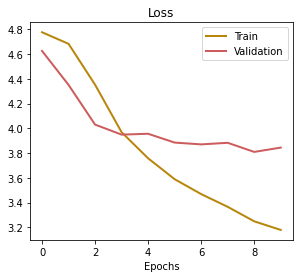

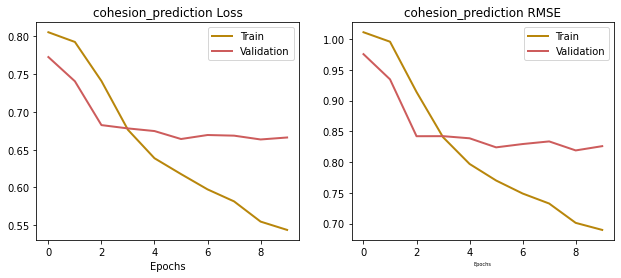

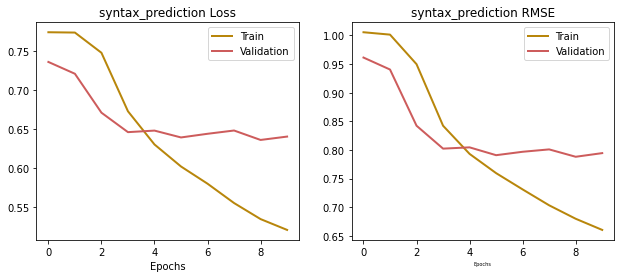

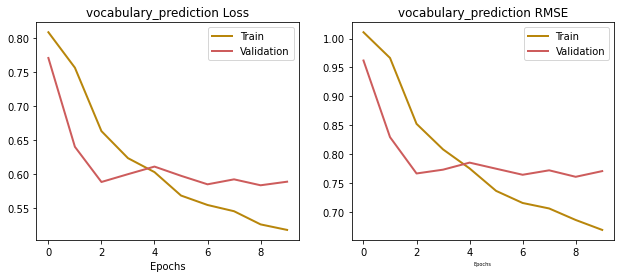

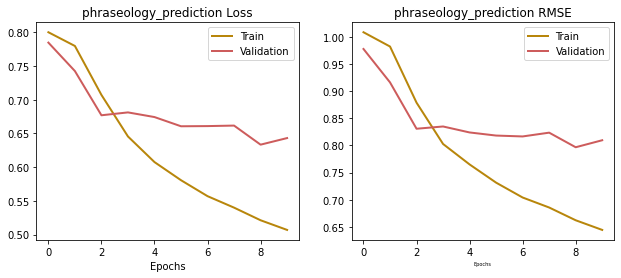

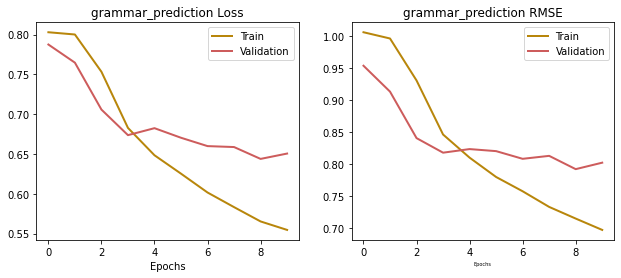

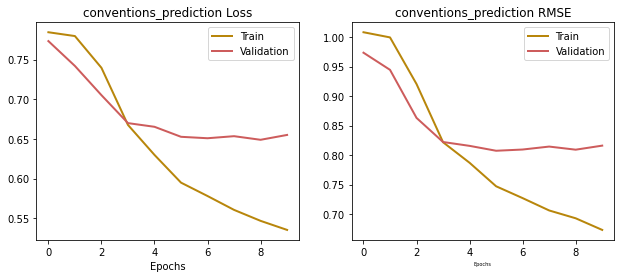

In [31]:
# grab history
history = hist.history


outputs = [ 'cohesion_prediction', 'syntax_prediction', 'vocabulary_prediction', 'phraseology_prediction', 'grammar_prediction', 'conventions_prediction' ]

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');
    

for output in outputs:
    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history[f'{output}_loss'], lw=2, color='darkgoldenrod')
    plt.plot(history[f'val_{output}_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title(f'{output} Loss');

    # plot accuracy for train and validation
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history[f'{output}_root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history[f'val_{output}_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.7,0.8)
    ax.set_xlabel('Epochs', size=5)
    ax.set_title(f'{output} RMSE');


In [ ]:
# predictions = grader.predict(encoded_essays_train[0:2])
# predictions = pd.DataFrame(np.array(predictions).reshape(6,2)).T
# sc_y.inverse_transform(predictions.values)

In [32]:
test_predictions = grader.predict(encoded_essays_test)
test_predictions = pd.DataFrame(np.array(test_predictions).reshape(6,-1)).T
test_predictions = sc_y.inverse_transform(test_predictions.values)
test_predictions = pd.DataFrame(test_predictions)
test_predictions
# test_predictions

,0,1,2,3,4,5
0,2.970705,2.781563,3.103414,2.943894,2.742248,2.777588
1,2.829078,2.739444,2.985047,2.833132,2.711839,2.772030
2,3.275634,3.174810,3.374298,3.280164,3.181003,3.214474


In [33]:
test['cohesion'] = test_predictions[0]
test['syntax'] = test_predictions[1]
test['vocabulary'] = test_predictions[2]
test['phraseology'] = test_predictions[3]
test['grammar'] = test_predictions[4]
test['conventions'] = test_predictions[5]
test

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.970705,2.781563,3.103414,2.943894,2.742248,2.777588
1,000BAD50D026,Do you think students would benefit from being...,2.829078,2.739444,2.985047,2.833132,2.711839,2.772030
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.275634,3.174810,3.374298,3.280164,3.181003,3.214474


In [34]:
res = test.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)